# Named Entity Recognition

#### Setup google Drive

In [1]:
# mounting drive to colab
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
# Get Project Directory in Google colab
import os
os.chdir('/content/drive/MyDrive/Projects/Named Entity Recognition')

In [3]:
!pwd

/content/drive/MyDrive/Projects/Named Entity Recognition


#### Imports 

In [4]:
# imports 
import pandas as pd
import numpy as np
import nltk
import pickle

# tensorflow
import tensorflow as tf
from tensorflow import keras

# tesorflow preprocessing 
from tensorflow.keras.preprocessing.sequence import pad_sequences

#sklearn
from sklearn.model_selection import train_test_split
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Load Data

In [5]:
# load data
data = pd.read_csv('./data/ner_dataset.csv',encoding='unicode_escape',skipinitialspace=True,skip_blank_lines=True)


In [6]:
data.shape

(1048575, 4)

In [7]:
data.head(13)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [8]:
# unique Tags 
data.Tag.unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

## Data Preprocessing

In [9]:
def get_vocab(all_word_list,all_tag_list):
  '''
  funciton to build vocabulary and return word2id and id2word and tag2id and id2tag
  '''
  # word vocabulary
  word_vocab = set(all_word_list)

  # tag vocabulary
  tag_vocab = set(all_tag_list)

  word2id = {word:id for id,word in enumerate(word_vocab)}
  id2word ={id:word for id,word in enumerate(word_vocab)}

  # Add Aditional index for 'UNKOWN WORDs' and 'PADDING'
  word2id['UNK'] = len(word_vocab) # adding at the end
  word2id['<PAD>'] = len(word_vocab) +1 # adding at the end

  id2word[len(word_vocab)]='UNK'
  id2word[len(word_vocab)+1] ='<PAD>'



  tag2id ={tag:id for id,tag in enumerate(tag_vocab)}
  id2tag ={id:tag for id,tag in enumerate(tag_vocab)}

  return word2id,id2word,tag2id,id2tag

In [10]:
# Build vocabulary of words ands tags 

word2id,id2word,tag2id,id2tag = get_vocab(data.Word,data.Tag)

In [11]:
# load vocabulary
import utils
#word2id,id2word,tag2id,id2tag = utils.load_voabularies()

In [12]:
# vocabulary size 
word_vocab_size = len(word2id)
tag_vocab_size = len(tag2id)

In [13]:
# Save word vocabulary and tag vocabulary
all_vocabs = [word2id,id2word,tag2id,id2tag]
vocab_names = ['word2id','id2word','tag2id','id2tag']

folder_path ='./trained vocab/'
for vocab_name,vocab in zip(vocab_names,all_vocabs):
  with open(folder_path + vocab_name +'.pickle','wb') as file:
    pickle.dump(vocab,file,protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
def load_voabularies():
  '''
  function to load all vocabularies for the project
  '''
  folder_path ='./trained vocab/'
  all_dictionaries = []
  vocab_names = ['word2id','id2word','tag2id','id2tag']
  for vocab_name in vocab_names:
    with open(folder_path + vocab_name+'.pickle','rb') as file:
      vocab=pickle.load(file)
      all_dictionaries.append(vocab)

  
  word2id,id2word,tag2id,id2tag = all_vocabs[0],all_vocabs[1],all_vocabs[2],all_vocabs[3]
  return word2id,id2word,tag2id,id2tag


In [15]:
w1,w2,t1,t2=load_voabularies()

In [16]:
word_vocab_size

35180

In [17]:
tag2id

{'B-art': 8,
 'B-eve': 3,
 'B-geo': 11,
 'B-gpe': 4,
 'B-nat': 10,
 'B-org': 7,
 'B-per': 15,
 'B-tim': 14,
 'I-art': 16,
 'I-eve': 6,
 'I-geo': 12,
 'I-gpe': 13,
 'I-nat': 0,
 'I-org': 5,
 'I-per': 9,
 'I-tim': 1,
 'O': 2}

In [18]:
# Map the entity codes 
tag2tag = {tag:tag[2:] for tag in tag2id.keys()}
tag2tag

{'B-art': 'art',
 'B-eve': 'eve',
 'B-geo': 'geo',
 'B-gpe': 'gpe',
 'B-nat': 'nat',
 'B-org': 'org',
 'B-per': 'per',
 'B-tim': 'tim',
 'I-art': 'art',
 'I-eve': 'eve',
 'I-geo': 'geo',
 'I-gpe': 'gpe',
 'I-nat': 'nat',
 'I-org': 'org',
 'I-per': 'per',
 'I-tim': 'tim',
 'O': ''}

### Data Cleaning

In [19]:
# Remove NANs in the data 
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [20]:
processed_data = data.ffill(axis=0)

In [21]:
processed_data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [22]:
# Append Sentences 1 
processed_data = processed_data.groupby(['Sentence #'])['Word','POS','Tag'].agg(lambda x : list(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [23]:
processed_data

,Word,POS,Tag
Sentence #,,,
Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo..."
Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,..."
Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O..."
Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]"
Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo..."
...,...,...,...
Sentence: 9995,"[Opposition, leader, Mir, Hossein, Mousavi, ha...","[NNP, NN, NNP, NNP, NNP, VBZ, VBN, PRP, VBZ, T...","[O, O, O, B-per, I-per, O, O, O, O, O, O, O, O..."
Sentence: 9996,"[On, Thursday, ,, Iranian, state, media, publi...","[IN, NNP, ,, JJ, NN, NNS, VBN, DT, NN, IN, DT,...","[O, B-tim, O, B-gpe, O, O, O, O, O, O, O, O, B..."
Sentence: 9997,"[Following, Iran, 's, disputed, June, 12, elec...","[VBG, NNP, POS, JJ, NNP, CD, NNS, ,, NNS, NNS,...","[O, B-geo, O, O, B-tim, I-tim, O, O, O, O, O, ..."


### One hot Encoding 

In [24]:
def get_index(words,word2id):
  '''
  funtion to convert tokenized words into list of indices in vocab
  also tags into list of indices in tag vocab
  input : words- Tokenized words
          word2id - Dictionary with {word,index in dictionary}
  output : list of indices
  '''
  # check if word is in dictionary otherwise return word2id['UNK']

  words_index =[word2id[word] if word in word2id
                else word2id['UNK']
                for word in words]

  return words_index

In [25]:
# create list of indices For Sentences and Tags 

sentence_ids = list(processed_data.Word.apply(lambda x:get_index(x,word2id)))
tag_ids = list(processed_data.Tag.apply(lambda x: get_index(x,tag2id)))

In [26]:
# find the max length of the sentence in training 
max_sentence_length = max([len(sent) for sent in sentence_ids])
max_sentence_tags_length = max([len(tags) for tags in tag_ids])

In [27]:
print('Max sentence length :',max_sentence_length)
print('Max_sentence tag length :',max_sentence_tags_length)

Max sentence length : 104
Max_sentence tag length : 104


## Train Test split

In [28]:
train_sent_ids,test_sent_ids,train_tags,test_tags = train_test_split(sentence_ids,tag_ids,test_size=0.2,random_state =0)

### Padding 

In [29]:
#  Pad the values 
#padded_sentence_ids = pad_sequences(sentence_ids,maxlen= max_sentence_length,value=word2id['the']) # add the padding value correspind to word 'the'
#padded_tag_ids = pad_sequences(tag_ids,maxlen= max_sentence_length, value = tag2id['O']) # add the index of the 'O'

In [30]:
# Pad values 

def pad_values(sentences,vocab,max_length,pad='<PAD>'):
  '''
  Function to pad the sequence 
  input : sentences - list of sequences 
        : vocab - dictionarary of {words,index in vocabulary}
        : max_length - padding length
        : pad - padd token represented in the vocabulary
  output : padded sequences
  '''
  from keras.preprocessing.sequence import pad_sequences

  padded_sentece = pad_sequences(sentences,maxlen= max_length,value=vocab[pad])
  return padded_sentece



In [31]:
X_train = pad_values(train_sent_ids,word2id,max_sentence_length)
X_test = pad_values(test_sent_ids,word2id,max_sentence_length)

y_train_tags = pad_values(train_tags,word2id,max_sentence_length)
y_test_tags = pad_values(test_tags,word2id,max_sentence_length)

### Convert Output to onehot Encoding

In [32]:
# one hot encoding 
#from tensorflow.keras.utils import to_categorical
#padded_tag_ids_one_hot = to_categorical(padded_tag_ids)
#print(padded_tag_ids_one_hot.shape)

In [33]:
def convert_to_onehot(y,word2id,tag2id,pad='<PAD>'):
  from tensorflow.keras.utils import to_categorical
  # replace the <PAD> with number assosiated with 'O' tag
  y_tags = y.copy()
  y_tags[y_tags==word2id[pad]] = tag2id['O']
  y_tags_one_hot = to_categorical(y_tags)
  return y_tags_one_hot
  

In [34]:
# one hot encoding
y_train =convert_to_onehot(y_train_tags,word2id,tag2id)
y_test = convert_to_onehot(y_test_tags,word2id,tag2id)

In [35]:
#X_train,X_test,y_train,y_test = train_test_split(padded_sentence_ids,padded_tag_ids_one_hot,test_size=0.2)

In [36]:
print('Training data shape :',X_train.shape)
print('Testing data shape :',X_test.shape)

print('Train Target label shape',y_train.shape)
print('Test Target label shape',y_test.shape)

Training data shape : (38367, 104)
Testing data shape : (9592, 104)
Train Target label shape (38367, 104, 17)
Test Target label shape (9592, 104, 17)


## Model 

In [37]:
# Model parameters 
input_length = max_sentence_length  # length of sentence or total words in the sentence
input_dim = word_vocab_size  
embedding_dim = 64  # output of embedding layer 

output_units = len(tag2id) #  Number of unique tags for classification

In [38]:
model = keras.Sequential()
# Embedding Layer
model.add(keras.layers.Embedding(input_dim=input_dim,
                                output_dim = embedding_dim,
                                input_length = input_length
                                ))
# 1st Bidirectional LSTM Layer
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128,
                                                       return_sequences=True,
                                                       dropout=0.2)))
# 2nd Bidirectional LSTM Layer
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128,
                                                       return_sequences=True,
                                                       dropout=0.2)))
# Output Dense Layer 
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units = output_units,
                                                          activation='softmax')))

# compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics =['acc',keras.metrics.Precision(),keras.metrics.Recall()]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 64)           2251520   
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 256)          197632    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 104, 256)          394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 17)           4369      
Total params: 2,847,761
Trainable params: 2,847,761
Non-trainable params: 0
_________________________________________________________________


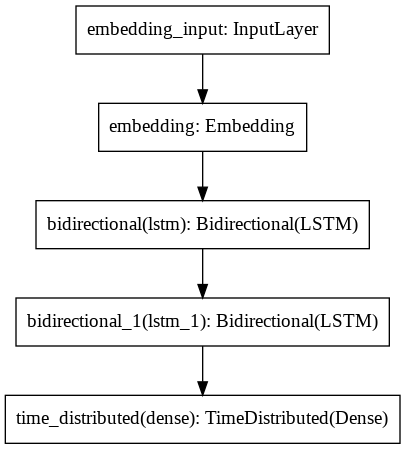

In [146]:
keras.utils.plot_model(model)

In [39]:
# Train the Model 
history=model.fit(X_train,y_train,
          validation_data =(X_test,y_test),
          epochs =15,
          batch_size=64,
          verbose=1,
          )

# save the model
model.save('trained_models/model2d_15e.h5')

# save training history
history_file = open('trained_models/hist_model2d_15e.pkl','wb')
pickle.dump(history.history,history_file)
history_file.close()


Epoch 1/15
600/600 [==============================] - 78s 109ms/step - loss: 0.1254 - acc: 0.9735 - precision: 0.9855 - recall: 0.9590 - val_loss: 0.0515 - val_acc: 0.9850 - val_precision: 0.9940 - val_recall: 0.9775
Epoch 2/15
600/600 [==============================] - 63s 106ms/step - loss: 0.0350 - acc: 0.9900 - precision: 0.9942 - recall: 0.9866 - val_loss: 0.0303 - val_acc: 0.9915 - val_precision: 0.9940 - val_recall: 0.9898
Epoch 3/15
600/600 [==============================] - 63s 105ms/step - loss: 0.0229 - acc: 0.9934 - precision: 0.9950 - recall: 0.9921 - val_loss: 0.0256 - val_acc: 0.9926 - val_precision: 0.9942 - val_recall: 0.9915
Epoch 4/15
600/600 [==============================] - 63s 105ms/step - loss: 0.0187 - acc: 0.9945 - precision: 0.9956 - recall: 0.9936 - val_loss: 0.0250 - val_acc: 0.9927 - val_precision: 0.9941 - val_recall: 0.9918
Epoch 5/15
600/600 [==============================] - 63s 104ms/step - loss: 0.0164 - acc: 0.9950 - precision: 0.9960 - recall: 0.99

## Evaluation

In [97]:
# pretrained models
#model = keras.models.load_model('trained_models/model2d_10e')


In [ ]:
# load training history
#with open('trained_models/hist_model_50e.pkl','rb') as file:
#  history = pickle.load(file)

In [40]:
def plot_graphs(history,string):
  import matplotlib.pyplot as plt
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()


def plot_saved_graphs(history,string):
  import matplotlib.pyplot as plt
  plt.plot(history[string])
  plt.plot(history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

#plot_graphs(history,'accuracy')
#plot_graphs(history,'loss')

In [42]:
history.history.keys()

dict_keys(['loss', 'acc', 'precision', 'recall', 'val_loss', 'val_acc', 'val_precision', 'val_recall'])

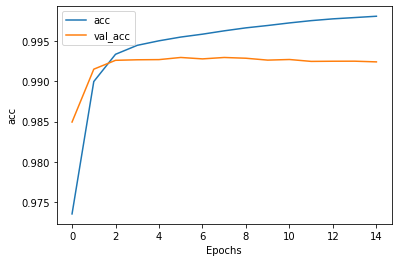

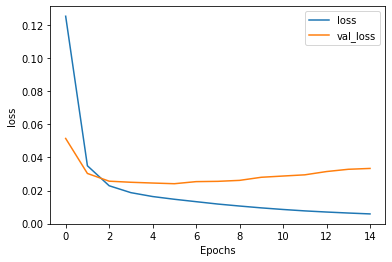

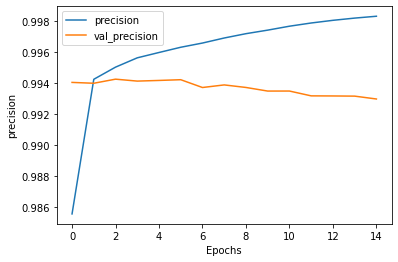

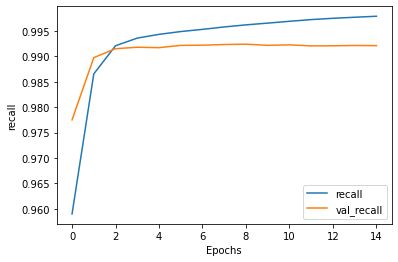

"\n# plot graphs \nplot_saved_graphs(history,'acc')\nplot_saved_graphs(history,'loss')\nplot_saved_graphs(history,'precision_1')\nplot_saved_graphs(history,'recall_1')\n"

In [43]:

plot_graphs(history,'acc')
plot_graphs(history,'loss')
plot_graphs(history,'precision')
plot_graphs(history,'recall')

'''
# plot graphs 
plot_saved_graphs(history,'acc')
plot_saved_graphs(history,'loss')
plot_saved_graphs(history,'precision_1')
plot_saved_graphs(history,'recall_1')
'''

### Evaluation on Test set

In [44]:
y_test_preditct = model.predict(X_test)

In [45]:
def evaluate_prediction(pred, labels,pad):

  outputs = np.argmax(pred,axis=2)
  print('outputs shape :',outputs.shape)

  # masking the padded valies 
  mask = labels!=pad
  print("mask shape:", mask.shape, "mask[0][:10]:", mask[0][:10])

  accuracy = np.sum(outputs==labels)/float(np.sum(mask))
  return accuracy



In [46]:
# calucate the accuracy 

accuracy = evaluate_prediction(y_test_preditct, y_test_tags, word2id['<PAD>'])
print("accuracy: ", accuracy)

outputs shape : (9592, 104)
mask shape: (9592, 104) mask[0][:10]: [False False False False False False False False False False]
accuracy:  0.9638539819413309


## Testing user data

In [50]:
# load the trained model
trained_model = keras.models.load_model('trained_models/model2d_15e.h5')

In [ ]:
#model =trained_model

In [47]:
max_sentence_length=104

def NER(sentence,model,word2id,id2tag,max_len = max_sentence_length):
  '''
  function to get Named Entity recoginition of text passed 
  Input : sentence - Input text in str
        : model - Model
        : word2id - dictionary with {word,index for word in vocab}
        : id2tag - dictionary with {id of tag, tag}
        : max_len  - maximum sentence length supported by model

  output : df - Dataframe with two columsn ['words','tokens'] ,
           tokens reprent the NER tags
  '''


  #1. tokenzie sentence 
  sent_token = nltk.word_tokenize(sentence)
  # check the sent_length is within acceptable range
  if len(sent_token)>max_len:
    sent_token = sent_token[:max_len-1]

  #2. convert to indices
  sent_indices = get_index(sent_token,word2id)
  #3. Pad 
  padded_sent = pad_values([sent_indices],word2id,max_len)
  #4. Prediction
  predicition = model.predict(padded_sent)
  # Prediction label
  prediction_label = np.argmax(predicition,axis=2)
  #prediction_label

  ## Map the entity codes 
  tag2tag = {id:tag[2:] for id,tag in id2tag.items()}

  df = pd.DataFrame()
  df['sent']=sent_token
  df['tokens']=np.array(pd.Series(prediction_label[0]).map(tag2tag)[-len(sent_token):])
  #print(df.to_string())
  return df


In [48]:
sentence = 'The Battle of Marais des Cygnes took place on October 25, 1864, in Linn County, Kansas, during Prices Missouri Raid in the American Civil War. A large Confederate cavalry incursion into Missouri in late 1864 attempted to draw Union troops away from the fighting further east. After several victories the Confederates were defeated at the Battle of Westport and withdrew into Kansas. They camped along the banks of the Marais des Cygnes River on the night of October 24 while Union cavalry pursuers skirmished with their rear guard. The battle began early the next morning as 3,500 Union troops drove this force from its position, capturing cannons, prisoners, and wagons. An attempted stand at the river crossing was outflanked by a Union cavalry regiment, forcing the Confederates to abandon it. A rear guard action by a 1,200-man Confederate brigade bought time to disengage and retreat. After two further defeats on the same day and another on October 28, the Confederates retreated to Texas. (Full article...)'

df1=NER(sentence,model,word2id,id2tag,max_len = max_sentence_length)

In [49]:
df1

,sent,tokens
0,The,
1,Battle,per
2,of,
3,Marais,
4,des,
...,...,...
98,began,
99,early,
100,the,
101,next,


In [54]:
sentence = 'The Battle of Marais des Cygnes took place on October 25, 1864, in Linn County, Kansas, during Prices Missouri Raid in the American Civil War. A large Confederate cavalry incursion into Missouri in late 1864 attempted to draw Union troops away from the fighting further east. After several victories the Confederates were defeated at the Battle of Westport and withdrew into Kansas. They camped along the banks of the Marais des Cygnes River on the night of October 24 while Union cavalry pursuers skirmished with their rear guard. The battle began early the next morning as 3,500 Union troops drove this force from its position, capturing cannons, prisoners, and wagons. An attempted stand at the river crossing was outflanked by a Union cavalry regiment, forcing the Confederates to abandon it. A rear guard action by a 1,200-man Confederate brigade bought time to disengage and retreat. After two further defeats on the same day and another on October 28, the Confederates retreated to Texas. (Full article...)'

df1=NER(sentence,trained_model,word2id,id2tag,max_len = max_sentence_length)
df1

,sent,tokens
0,The,
1,Battle,per
2,of,
3,Marais,
4,des,
...,...,...
98,began,
99,early,
100,the,
101,next,


In [86]:
tag2color ={
    '':'#F8F8FF',    # ghostwhite    
    'art':'#FF6A6A', # indian red 
    'eve':'#FF7D40', # flesh - orangish
    'geo':'#7FFF00', # chartreuse1 - greenish
    'gpe':'#FFD700', # gold1
    'nat':'#C0FF3E', # olivedrab1
    'org':'#87CEFA', # lightskyblue
    'per':'#E066FF', # mediumorchid1
    'tim':'	#CDC1C5'# lavenderblush3
}

In [109]:
def get_annoted_text(df,tag2color):
  df1= df.copy()
  df1['color'] = df1['tokens'].map(tag2color)

  # text in annotated text format
  #('word','entity name','color)
  anotated_text_list =[tuple(df1.iloc[i,:2]) if df1.iloc[i,2]=='#FF6A6A' 
                       else tuple(df1.iloc[i,:]) 
                       for i in range(len(df1))]
   

  return anotated_text_list

In [110]:
get_annoted_text(NER(sentence,model,word2id,id2tag,max_len = max_sentence_length),tag2color)

[('The', 'art'),
 ('Battle', 'art'),
 ('of', 'art'),
 ('Marais', 'art'),
 ('des', 'art'),
 ('Cygnes', 'art'),
 ('took', 'art'),
 ('place', 'art'),
 ('on', 'art'),
 ('October', 'art'),
 ('25', 'org', '#87CEFA'),
 (',', 'art'),
 ('1864', 'tim', '\t#CDC1C5'),
 (',', 'art'),
 ('in', 'art'),
 ('Linn', 'eve', '#FF7D40'),
 ('County', 'geo', '#7FFF00'),
 (',', 'art'),
 ('Kansas', 'geo', '#7FFF00'),
 (',', 'art'),
 ('during', 'art'),
 ('Prices', 'art'),
 ('Missouri', 'eve', '#FF7D40'),
 ('Raid', 'geo', '#7FFF00'),
 ('in', 'art'),
 ('the', 'art'),
 ('American', 'art'),
 ('Civil', 'art'),
 ('War', 'art'),
 ('.', 'art'),
 ('A', 'eve', '#FF7D40'),
 ('large', 'art'),
 ('Confederate', 'geo', '#7FFF00'),
 ('cavalry', 'geo', '#7FFF00'),
 ('incursion', 'geo', '#7FFF00'),
 ('into', 'geo', '#7FFF00'),
 ('Missouri', 'geo', '#7FFF00'),
 ('in', 'art'),
 ('late', 'art'),
 ('1864', 'tim', '\t#CDC1C5'),
 ('attempted', 'art'),
 ('to', 'art'),
 ('draw', 'art'),
 ('Union', 'art'),
 ('troops', 'tim', '\t#CDC1C5'),


# Streamlit app


### Install Streamlit and ngrok

In [4]:
from os import path
# install streamlit
!pip install streamlit -q
!pip install st-annotated-text -q

# dowload the ngrok package

if not path.exists('ngrok'):
  !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
  #unzip the files 
  !unzip ngrok-stable-linux-amd64.zip

def get_ngrok_link():  
  # installation
  get_ipython().system_raw('./ngrok http 8501 &')

  # get the app link
  !curl -s http://localhost:4040/api/tunnels | python3 -c \
      'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

     |████████████████████████████████| 8.3 MB 4.5 MB/s 
     |████████████████████████████████| 111 kB 15.6 MB/s 
     |████████████████████████████████| 76 kB 4.3 MB/s 
     |████████████████████████████████| 180 kB 57.7 MB/s 
     |████████████████████████████████| 4.3 MB 38.5 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 124 kB 71.6 MB/s 
     |████████████████████████████████| 788 kB 57.7 MB/s 
     |████████████████████████████████| 374 kB 58.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.21 which is incompatible.
google-colab 1.0.0 requires ipykernel~=4.10, but you have ipykernel 6.4.2 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.28.0 which is incompatibl

## Streamlit app code 

In [6]:
get_ngrok_link()

Execute the next cell and the go to the following URL: https://c23c-35-229-100-204.ngrok.io


In [7]:
!streamlit run app.py


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://35.229.100.204:8501

2021-10-26 18:05:10.966747: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-26 18:05:10.966818: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (da70e48e36c3): /proc/driver/nvidia/version does not exist
2021-10-26 18:05:49.057 Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/streamlit/script_runner.py", line 354, in _run_script
    exec(code, module.__dict__)
  File "/content/drive/My Drive/Projects/Named Entity Recognition/app.py", line 75, in <module>
    output_text =get_ner(input_text)
  File "/content/drive/My Drive/Projects/Named Entity Recognition/app.py", line 40, in get_ner
    ner_df = utils.NER(text,model,word2id,id2tag,max_len = max_sentence_leng

In [9]:
# freeze requirement 
!pip freeze >requirements.txt